# Toy atmosphere model

Includes the effects from molecular Rayleigh scattering, stellar spots and contamination

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from core import *
from scipy.optimize import fmin
from emcee import EnsembleSampler
from exotk.priors import UP,NP,PriorSet
from pyde.de import DiffEvol
from exotk.utils.eclipses import Planck
from exotk.constants import rsun, rjup, mjup
from scipy.constants import k, G, proton_mass

## Define the model and log posterior function

In [15]:
def contamination(wl,c0,Ts,Tc,return_components=False):
    flux_s = Planck(Ts, wl)
    flux_c = Planck(Tc, wl)
    
    flux_s = (1-c0)* (flux_s/flux_s[0])
    flux_c =    c0 * (flux_c/flux_c[0]) 
    flux_t  = flux_c + flux_s
    
    if not return_components:
        return flux_c / flux_t
    else: 
        return flux_t, flux_s, flux_c
    
    
def contaminated_k(wl, k0, Tc, c0, Ts):
    return k0*sqrt(1-contamination(wl, c0, Ts, Tc))

def spotty_k(wl, k0, Tstar, f, DeltaT):
    """
    Modified radius ratio due to unocculted spots.
    
    Parameters
    
      wl     : wavelength [m]
      k0     : true geometric radius ratio
      Tstar  : effective stellar temperature [K]
      f      : spot filling factor
      DeltaT : spot temperature difference [K]
    """
    Tspot    = Tstar - DeltaT
    fratio   = Planck(Tspot,wl)/Planck(Tstar,wl)
    contrast = 1 - fratio
    
    return k0*sqrt(1/(1-f*contrast))

def final_k(wl, Tstar, k0, f_spot, DeltaT, c0, Tc):
    k_spot = spotty_k(wl, k0, Tstar, f_spot, DeltaT)
    k_cont = contaminated_k(wl, k_spot, Tc, c0, Tstar)
    return k_cont


def basic_model(pv, wl):
    lwl = log(wl)
    h = H(pv[1], 10**LOGGP*1e-2)
    A = -4*h/RSTAR
    C = pv[0] - A*log(pv[2]) 
    k_rl = A*lwl+C
    return clip(k_rl, pv[0], 1e19)


def mixed_model(pv, wl, Tstar):
    """
    Parameter vector
    0 k0 : constant cloud level                   [Rstar]
    1 TP : Planet temperature                     [K]
    2 λ0 : rayleigh-cloud intersection wavelength [m]
    3 fs : spot coverage fraction                 [-]
    4 ΔT : spot temperature difference            [K]
    5 fc : contamination factor                   [-]
    6 Tc : contaminant temperature                [K]
    """
    k = basic_model(pv[:3], wl)
    k = final_k(wl, Tstar, k, *pv[3:])
    return k


class LPFunction(object):
    def __init__(self, wl, k, ke):
        self.wl = wl
        self.k  = k
        self.ke = ke
        self.n  = k.size
        self.A  = 0.5*self.n*log(2*pi)
        self.B  = log(self.ke).sum()
                
        priors = [NP(0.167, 0.005, 'k0', lims=(0.15,0.20)),
                  UP( TEQ,  50*TEQ, 'TP'),
                  UP( 600e-9, 800e-9, 'l0'),
                  UP( 0.01, 0.50, 'f_spot'),
                  NP( 1700,  200, 'dt_spot', lims=(500,2500)),
                  NP( 0.01, 5e-3, 'f_cont', lims=(0.001,0.02)),
                  UP( 3000, 5500, 't_cont')]
        self.ps = PriorSet(priors)
        
    def model(self, pv):
        return mixed_model(pv, self.wl, TSTAR)
    
    def log_likelihood(self, pv):
        chi2 = (((self.k-self.model(pv))/self.ke)**2).sum()
        return -self.A - self.B - 0.5*chi2
    
    def log_posterior(self, pv):
        if any(pv < self.ps.bounds[:,0]) | any(pv > self.ps.bounds[:,1]):
            return -inf
        
        return self.ps.c_log_prior(pv) + self.log_likelihood(pv)

    
def T_from_H(H, mu=None):
    g  = G*1.91*mjup/(0.174*rstar)**2
    mu = mu or 2.3*proton_mass
    return H*mu*g/k

The basic (toy) model contains Rayleigh scattering and a constant cloud base. For pure rayleigh scattering, we get  
$$
 k_R = \alpha H / R_\star \ln \lambda + C = -4 H / R_\star \ln \lambda + C = A \ln\lambda + C
$$
where $H = \frac{kT}{\mu g}$ is the atmospheric scale height. The constant $C$ can be calculated given a reference wavelength $\lambda_0$ and radius ratio $k_0$ as
$$
 C = k_0 -A\ln\lambda_0
$$

Parameterisation $\theta_0$ is the constant cloud base level, $\theta_1 = H$, and $\theta_2$ is the reference wavelength $\lambda_0$, chosen to be the wavelength where the Rayleigh slope meets the cloud base.

## Run DE and MCMC

In [16]:
dfk = pd.read_hdf('results/pe.h5','nb/radius_ratios/gp_masked')
kes = array(percentile(dfk, [50,16,84], 0))
km, ke = kes[0,:], abs(kes[1:,:]-kes[0,:]).mean(0)

In [17]:
lpf = LPFunction(1e-9*pb_centers, km, ke)
de = DiffEvol(lpf.log_posterior, lpf.ps.bounds, 100, maximize=True)
sampler = EnsembleSampler(100, lpf.ps.ndim, lpf.log_posterior)

In [18]:
de.optimize(500);

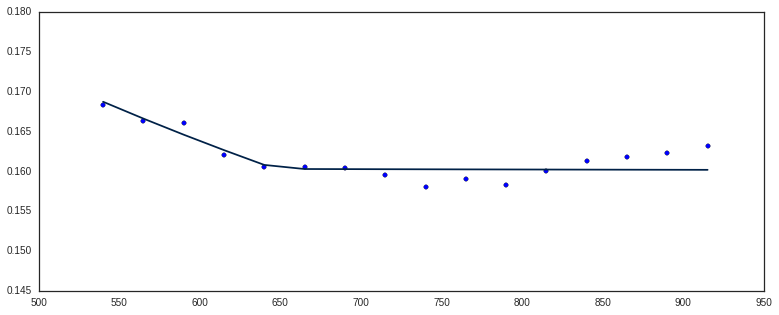

In [19]:
scatter(pb_centers, km)
plot(pb_centers, lpf.model(de.minimum_location));

In [20]:
sampler.run_mcmc(de.population, 500);
pv0 = sampler.chain[:,-1,:].copy()
sampler.reset()
sampler.run_mcmc(pv0, 1000);
pv0 = sampler.chain[:,-1,:].copy()
sampler.reset()
sampler.run_mcmc(pv0, 4000);

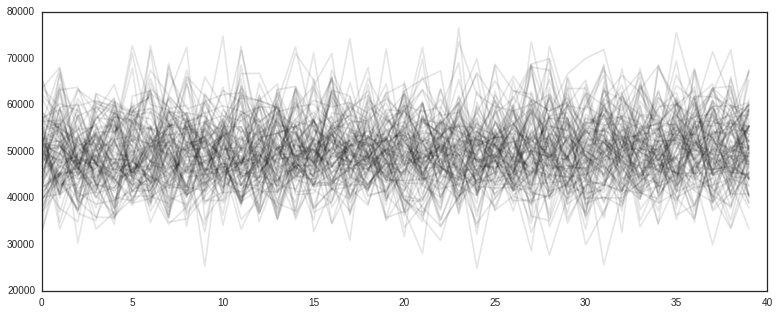

In [21]:
plot(sampler.chain[:,::100,1].T, 'k', alpha=0.1);

In [22]:
fc = sampler.chain[:,::50,:].reshape([-1,lpf.ps.ndim])
mp = median(fc,0)

In [23]:
kpd = array([mixed_model(pv, 1e-9*pb_centers, 5650) for pv in fc[permutation(fc.shape[0])[:500]]])
kmed,kmin,kmax = percentile(kpd, [50, 16,84], 0)

In [24]:
H(3*TEQ, 10**LOGGP*1e-2)

616018.7145342234

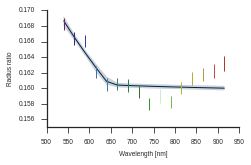

In [25]:
with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        fig, ax = subplots(1,1,figsize=(AAOCW,0.65*AAOCW))
        ax.fill_between(pb_centers, kmin, kmax, alpha=0.2)
        ax.plot(pb_centers, kmed)
        for i in range(km.size):
            c = sb.desaturate(cm.nipy_spectral(.1+i/19.), 0.5)
            a = 1 if i != 9 else 0.25
            ax.errorbar(pb_centers[i:i+1], km[i:i+1], ke[i:i+1], fmt='.', c=c, zorder=100, alpha=a)
        sb.despine(fig)
        setp(ax, ylim=(0.155,0.170), xlabel='Wavelength [nm]', ylabel='Radius ratio')
        fig.tight_layout()    
        #fig.savefig('plots/pub_spectrum_model_rayleigh_color.pdf')